# The Source Code for Lab Exercise 3.
## Steps
1. Preprocess the Data.
2. Create a Train and Test Split
3. Create a Convolutional Neural Network using Keras.
4. Experiment on Various Elements
5. Discussion and Analysis of Experiments.

# Possible Things to Experiment on
1. Other Preprocessing methods for Images.
2. Adding Max Pooling.
3. Changing number of Filters.
4. Changing Kernel Size.
5. Changing Learning Rate.
6. Changing Optimizers.
7. TBA

### Checking the Dataset for valid Image types

In [97]:
from pathlib import Path
import imghdr
import os

DATA_DIR = "hair_types"
IMAGE_EXTENSIONS = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

### Preprocessing Images and Creating Train/Test Splits using Keras util methods
#### Learn more:
```
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
```

In [98]:
# Import Tensorflow and Keras
import tensorflow as tf
import keras

# Define Sizes of Images
BATCH_SIZE = 32
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

### Preprocessing images from Scratch

In [99]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory="hair_types/",
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,    
    subset="training",
)
val_dataset = keras.utils.image_dataset_from_directory(
    directory="hair_types/",
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,    
    validation_split=0.2,
    subset="validation"
)
class_names = train_dataset.class_names
print(class_names)


Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.
['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


### Visualizing the Initial Dataset

2024-04-15 19:27:57.130562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


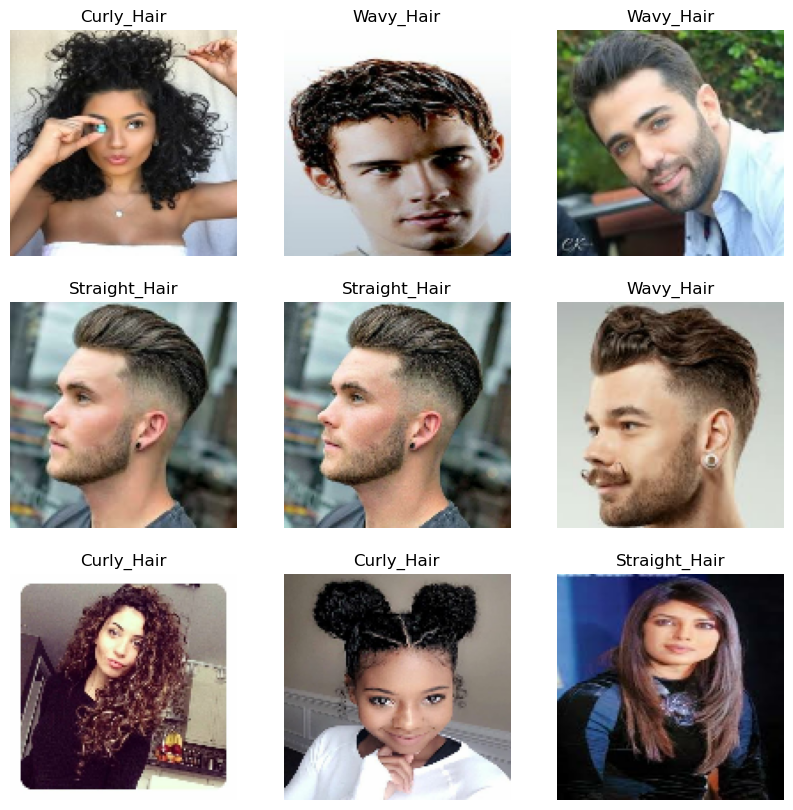

In [100]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

#### Data Augmentation

##### We first rescale all images depending on the batch size and image size

In [101]:
from keras import layers
resize_and_rescale = keras.Sequential([
    layers.Resizing(height=HEIGHT, width=WIDTH),
    layers.Rescaling(1./255),
])

##### Since the image data is not that many, we artificially produce sample images by flipping or rotating the present images.

In [102]:
# 1. Other ways to prefetch data
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
])

#### Visualizing Data Augmentation

2024-04-15 19:27:58.322216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


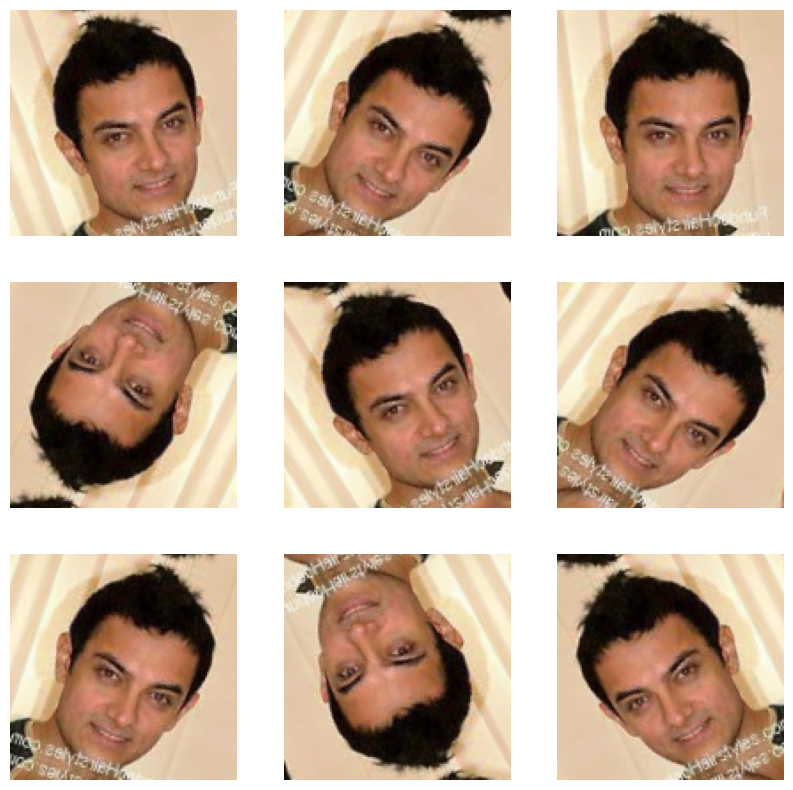

In [103]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

### GPU Optimization

##### We prefetch our data

In [104]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE)

### Creating the CNN Model

In [105]:
# 2. Adding Max Pooling.
# 3. Changing number of Filters.
# 4. Changing Kernel Size.
from keras import regularizers
model = keras.Sequential([
    # Data Preprocessing layers
    resize_and_rescale,
    data_augmentation,

    # Convolutional Layers
    layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2),
    layers.BatchNormalization(synchronized=True),
    layers.Activation(activation="relu"),
    layers.Dropout(rate=0.2),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2),
    layers.BatchNormalization(synchronized=True),
    layers.Activation(activation="relu"),
    layers.Dropout(rate=0.2),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2),
    layers.BatchNormalization(synchronized=True),
    layers.Activation(activation="relu"),
    layers.Dropout(rate=0.2),
    layers.MaxPooling2D(pool_size=2),
    
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2),
    layers.BatchNormalization(synchronized=True),
    layers.Activation(activation="relu"),
    layers.Dropout(rate=0.2),
    layers.MaxPooling2D(pool_size=2),

    # Flatten and Dense Layers
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=32, activation="relu"),
    layers.Dropout(rate=0.2),

    # Output Layer
    layers.Dense(units=3, activation="softmax"),
])

### Training of the Model

In [106]:
# 5. Changing Learning Rate.
# 6. Changing Optimizers.
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1, factor=0.5, min_lr=0.00001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [107]:
EPOCHS = 50
cnn = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)
model.summary()

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.4164 - loss: 2.7937 - val_accuracy: 0.3469 - val_loss: 2.4424
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4473 - loss: 2.3333 - val_accuracy: 0.3673 - val_loss: 2.1919
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5520 - loss: 2.0328 - val_accuracy: 0.3827 - val_loss: 1.9843
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5139 - loss: 1.7982 - val_accuracy: 0.3673 - val_loss: 1.8198
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5490 - loss: 1.6585 - val_accuracy: 0.3673 - val_loss: 1.7051
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5448 - loss: 1.5537 - val_accuracy: 0.3673 - val_loss: 1.6285
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6019 - loss: 1.3917 - val_accuracy: 0.3673 - val_loss: 1.5890
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5766 - loss: 1.3239 - val_accuracy: 0.

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_21 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             

 Total params: 306,923 (1.17 MB)

 Trainable params: 102,147 (399.01 KB)

 Non-trainable params: 480 (1.88 KB)

 Optimizer params: 204,296 (798.04 KB)

### Evaluation of the Model

In [108]:
keras.utils.plot_model(model=model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [109]:
img_path = "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Predict probabilities
predictions = model.predict(img_array)[0]  

# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
This image is 76.89 percent Curly Hair, 19.47 percent Straight Hair, 3.64 percent Wavy Hair.


### Predicting a Random Image

hair_types/Curly_Hair/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image is 63.39 percent Curly Hair, 30.04 percent Straight Hair, 6.57 percent Wavy Hair.


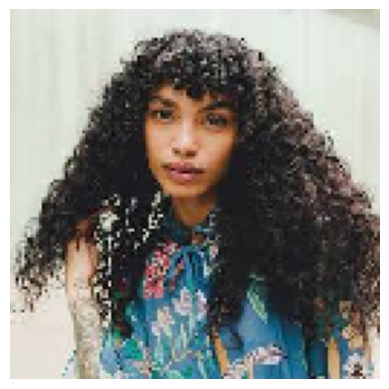

In [110]:
import os
import random
folder_number = random.randint(1, 3)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)

image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]


# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization of Model with respect to Epochs

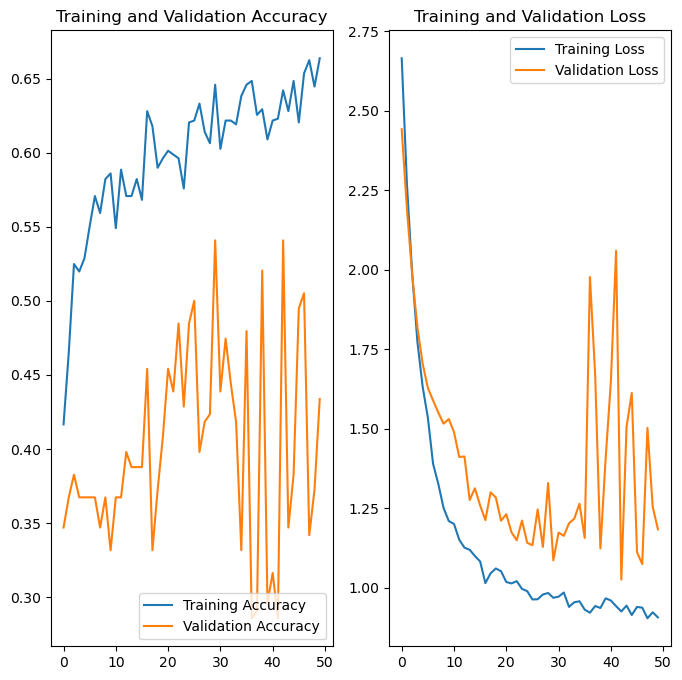

In [111]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']

loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()